# Probabilistic Machine Learning - Project Report

**Course:** Probabilistic Machine Learning (SoSe 2025) <br>
**Lecturer:** Dr Alvaro Diaz-Ruelas <br>
**Student(s) Name(s):** Lukas Becker <br>
**GitHub Username(s):**  lbegit <br>
**Date:**  15052025 <br>
**PROJECT-ID:** 15-2BLXXXX_epa_census <br>

---

## 1 Introduction

In recent years, transportation equity and sustainability have become central concerns in urban planning and policy. Among the key indicators of social and infrastructural access is household vehicle ownership, particularly the percentage of households without access or need to a private vehicle. These zero-vehicle households are often more dependent on public transit and walkable environments, and their distribution is shaped by a complex mix of socio-economic, spatial, and infrastructural variables.

This research aims to predict the percentage of car-free households in new and changed US Census Block Groups (CBGs). It is using the US EPA’s Smart Location Database (SLD), a rich source of standardized spatial and socio-economic indicators. The focus is on identifying how evolving social, economic, or political changes, such as new transit infrastructure, economic shifts, or population dynamics, can influence car ownership trends.

To model these dynamics, I will explore a range of machine learning techniques, from linear models like OLS, Lasso, Ridge, Elastic Net, and Bayesian Ridge regression to more sophisticated approaches such as k-Nearest Neighbors and Random Forest. The goal is to determine which models best capture the nuanced, multidimensional patterns influencing car ownership at the CBG level.


The analysis will be conducted using a carefully selected subset of variables from the SLD dataset, chosen for their theoretical relevance and practical predictive potential. These features span demographic composition, employment density, urban design, and transit access. All of which are thought to influence household decisions regarding car ownership.

## 2 Data Loading and Exploration

### 2.1 Prerequisites

#### (i) Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression , Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import statsmodels.api as sm

#### (ii) Functions

In [2]:
def compare_l1_l2_elastic(X_train, X_test, y_train, y_test, dataset_name):
    alphas = np.logspace(-3, 3, 50)
    lasso_mse = []
    ridge_mse = []
    elastic_mse = []

    for alpha in alphas:
        lasso = Lasso(alpha=alpha, max_iter=10000)
        ridge = Ridge(alpha=alpha)
        elastic = ElasticNet(alpha=alpha, l1_ratio=0.5, max_iter=10000)

        lasso.fit(X_train, y_train)
        ridge.fit(X_train, y_train)
        elastic.fit(X_train, y_train)

        y_pred_lasso = lasso.predict(X_test)
        y_pred_ridge = ridge.predict(X_test)
        y_pred_elastic = elastic.predict(X_test)

        lasso_mse.append(mean_squared_error(y_test, y_pred_lasso))
        ridge_mse.append(mean_squared_error(y_test, y_pred_ridge))
        elastic_mse.append(mean_squared_error(y_test, y_pred_elastic))

    plt.figure(figsize=(8,6))
    plt.plot(alphas, lasso_mse, label='Lasso (L1)', marker='o')
    plt.plot(alphas, ridge_mse, label='Ridge (L2)', marker='x')
    plt.plot(alphas, elastic_mse, label='Elastic Net', marker='s')
    plt.xscale('log')
    plt.xlabel('Regularization strength (alpha)')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title(f'Comparison of L1, L2 and Elastic Net Regularization on {dataset_name} Dataset')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\nBest Lasso (L1) MSE for {dataset_name}: {np.min(lasso_mse):.3f} at alpha={alphas[np.argmin(lasso_mse)]:.3f}")
    print(f"Best Ridge (L2) MSE for {dataset_name}: {np.min(ridge_mse):.3f} at alpha={alphas[np.argmin(ridge_mse)]:.3f}")
    print(f"Best Elastic Net MSE for {dataset_name}: {np.min(elastic_mse):.3f} at alpha={alphas[np.argmin(elastic_mse)]:.3f}")



In [3]:
def metrics(y_test, y_pred):
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print results
    print(f"Mean Squared Error (MSE): {mse:.6f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
    print(f"Mean Absolute Error (MAE): {mae:.6f}")
    print(f"R² (Coefficient of Determination): {r2:.4f}")

#### (iii) Settings

In [4]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 1000) # Show all columns

### 2.2 Data

#### (i) Preselection of Features

In [5]:
#df = pd.read_csv('/Users/z3/Documents/Studium/1. Semester/ProbML/SmartLocation/EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv')

In [6]:
#selected_df = df[['STATEFP','COUNTYFP','TRACTCE','BLKGRPCE','CSA','CSA_Name','CBSA','CBSA_Name','CBSA_POP','CBSA_EMP','CBSA_WRK','TotPop','HH','P_WrkAge','Pct_AO0','Workers','R_PCTLOWWAGE','TotEmp','E_PctLowWage','D1A','D1B','D1C','D2A_JPHH','D3A','D4A','D4C']].rename(columns={
#'STATEFP': 'STATE_ID','COUNTYFP': 'COUNTY_ID','TRACTCE':'Tract_ID','BLKGRPCE':'Block_Group','CSA': 'CSA','CSA_Name': 'CSA_NAME','CBSA': 'CBSA','CBSA_Name': 'CBSA_NAME','CBSA_POP': 'CBSA_POP','CBSA_EMP': 'CBSA_EMP','CBSA_WRK': 'CBSA_WRK','TotPop': 'TOTAL_POPULATION','HH': 'HOUSEHOLDS','P_WrkAge': 'P_WORKING_AGE','Pct_AO0': 'P_ZERO_CARS_HOUSEHOLDS','Workers': 'WORKERS','R_PCTLOWWAGE': 'P_LOW_WAGE_WORKERS','TotEmp': 'TOTAL_EMPLOYMENT','E_PctLowWage': 'P_LOW_WAGE_EMPLOYMENT','D1A': 'HOUSEHOLD_P_ACRE','D1B': 'POPULATION_P_ACRE','D1C': 'JOBS_P_ACRE', 'D2A_JPHH' : 'JOBS_P_HOUSEHOLD','D3A': 'ROAD_NETWORK_MILES','D4A': 'METERS_NEXT_TRANSIT_STOP','D4C': 'TIMES_P_HOUR_TRANSIT_SERVICE'})


In [7]:
#selected_df.tob_csv('census_data', index=False) 

#### (ii) Feature Description 

| **Column Name**                | **Original Name** | **Description**                                         | **Important for Prediction?** | **Relevance to Car Ownership**                                                              |
| ------------------------------ | ----------------- | ------------------------------------------------------- | ----------------------------- | ------------------------------------------------------------------------------------------- |
| `STATE_ID`                     | `STATEFP`         | State FIPS                                              | No                            | Record identifier |
| `COUNTY_ID`                    | `COUNTYFP`        | County FIPS                                             | No                            | Record identifier |
| `Tract_ID`                     | `TRACTCE`         | Census Tract identifier                                | No                            | Record identifier |
| `Block_Group`                  | `BLKGRPCE`        | Census Block Group code                                | No                            | Record identifier |
| `CSA`                          | `CSA`             | Combined Statistical Area code                         | No                            | Record identifier |
| `CSA_NAME`                     | `CSA_Name`        | Name of the CSA                                        | No                            | Record identifier |
| `CBSA`                         | `CBSA`            | Core-Based Statistical Area code                       | No                            | Record identifier |
| `CBSA_NAME`                    | `CBSA_Name`       | Name of the CBSA                                       | No                            | Record identifier |
| `CBSA_POP`                     | `CBSA_POP`        | Total population in the CBSA                           | Yes                           | Indicates scale of urbanization, which affects transit and car dependency                  |
| `CBSA_EMP`                     | `CBSA_EMP`        | Total employment in CBSA                               | Yes                           | Economic size often correlates with public transportation investment and job accessibility |
| `CBSA_WRK`                     | `CBSA_WRK`        | Workers living in the CBSA                             | Yes                           | Reflects commuting patterns and urban form                                                 |
| `TOTAL_POPULATION`             | `TotPop`          | Total population of the CBG                            | Yes                           | More people can imply denser neighborhoods with better transit                             |
| `HOUSEHOLDS`                   | `HH`              | Number of occupied households                          | Yes                           | Base unit for computing car ownership and household ratios                                 |
| `P_WORKING_AGE`                | `P_WrkAge`        | Percent of population aged 18–64                       | Yes                           | Working-age population drives demand for work-related travel                               |
| `P_ZERO_CARS_HOUSEHOLDS`       | `Pct_AO0`         | Percent of households with zero cars                   | **Target**                    | **This is the variable being predicted**                                                   |
| `WORKERS`                      | `Workers`         | Count of workers living in CBG                         | Yes                           | High numbers of workers may increase car ownership unless transit is strong                |
| `P_LOW_WAGE_WORKERS`           | `R_PCTLOWWAGE`    | Share of workers earning ≤\$1,250/month                | Yes                           | Low-income households are more likely to be car-free                                       |
| `TOTAL_EMPLOYMENT`             | `TotEmp`          | Number of jobs located in the CBG                      | Yes                           | More nearby jobs may reduce need for car commuting                                         |
| `P_LOW_WAGE_EMPLOYMENT`        | `E_PctLowWage`    | Share of local jobs that are low wage                  | Yes                           | Indicates local affordability and types of employment accessible without a car             |
| `HOUSEHOLD_P_ACRE`             | `D1A`             | Residential density (HHs per acre of unprotected land) | Yes                           | Denser housing often supports transit and walking                                          |
| `POPULATION_P_ACRE`            | `D1B`             | Population density per acre                            | Yes                           | Key factor in predicting transit viability and car ownership                               |
| `JOBS_P_ACRE`                  | `D1C`             | Job density per acre                                   | Yes                           | Dense employment centers reduce reliance on personal vehicles                              |
| `JOBS_P_HOUSEHOLD`             | `D2A_JPHH`        | Ratio of jobs to households                            | Yes                           | Indicates job-housing balance, affecting travel needs                                      |
| `ROAD_NETWORK_MILES`      | `D3A`           | Miles roads per square mile           | Yes                           | Roads are mostly car-oriented infrastructure and often correlate with higher car ownership                |
| `METERS_NEXT_TRANSIT_STOP`     | `D4A`             | Distance to nearest transit stop (meters)              | Yes                           | Key factor—longer distances reduce the viability of car-free living                        |
| `TIMES_P_HOUR_TRANSIT_SERVICE` | `D4C`             | Frequency of transit service near CBG during peak hour | Yes                           | More frequent service supports households not owning cars                                  |


#### (iii) Load

In [8]:
# Load csv 
df_org = pd.read_csv('/Users/z3/Documents/Studium/1. Semester/ProbML/Probabilistic-Machine-Learning_lecture-PROJECTS/projects/15-2BLXXXX_epa_census/data/census_data')

In [9]:
df = df_org.copy()

### 2.3 Preparation

#### (i) Null-Values

In [10]:
df.isnull().sum()

STATE_ID                            0
COUNTY_ID                           0
Tract_ID                            0
Block_Group                         0
CSA                             53031
CSA_NAME                        53031
CBSA                            17095
CBSA_NAME                       17095
CBSA_POP                            0
CBSA_EMP                            0
CBSA_WRK                            0
TOTAL_POPULATION                    0
HOUSEHOLDS                        275
P_WORKING_AGE                       0
P_ZERO_CARS_HOUSEHOLDS              0
WORKERS                             0
P_LOW_WAGE_WORKERS                  0
TOTAL_EMPLOYMENT                    0
P_LOW_WAGE_EMPLOYMENT               0
HOUSEHOLD_P_ACRE                  271
POPULATION_P_ACRE                   0
JOBS_P_ACRE                         0
JOBS_P_HOUSEHOLD                    0
ROAD_NETWORK_MILES                  0
METERS_NEXT_TRANSIT_STOP            0
TIMES_P_HOUR_TRANSIT_SERVICE        0
dtype: int64

##### Missing CSA and CBSA Values
I have a lot of Null-Values in CSA and CBSA Columns. These are just additional location information and no features. I will not use them in the model. They are only useful to get information about individual elements. But they are correlated with zero values in CBSA_POP, CBSA_EMP, CBSA_WRK. These Features should and will not be used in the model. 

In [11]:
df[(df['CBSA_POP']==0) | (df['CBSA_EMP']==0) | (df['CBSA_WRK']==0)]

,STATE_ID,COUNTY_ID,Tract_ID,Block_Group,CSA,CSA_NAME,CBSA,CBSA_NAME,CBSA_POP,CBSA_EMP,CBSA_WRK,TOTAL_POPULATION,HOUSEHOLDS,P_WORKING_AGE,P_ZERO_CARS_HOUSEHOLDS,WORKERS,P_LOW_WAGE_WORKERS,TOTAL_EMPLOYMENT,P_LOW_WAGE_EMPLOYMENT,HOUSEHOLD_P_ACRE,POPULATION_P_ACRE,JOBS_P_ACRE,JOBS_P_HOUSEHOLD,ROAD_NETWORK_MILES,METERS_NEXT_TRANSIT_STOP,TIMES_P_HOUR_TRANSIT_SERVICE
78,48,421,950200,2,NaN,NaN,NaN,NaN,0,0,0,1718,585.0,0.590,0.034188,454,0.196035,611,0.170213,1.038652,2.541886,0.904012,1.044444,21.685255,-99999.0,-99999.0
301,48,331,950700,3,NaN,NaN,NaN,NaN,0,0,0,541,220.0,0.416,0.068182,402,0.233831,245,0.200000,0.250029,0.491875,0.222753,1.113636,7.396807,-99999.0,-99999.0
302,48,331,950700,4,NaN,NaN,NaN,NaN,0,0,0,861,431.0,0.696,0.081206,419,0.264916,300,0.186667,0.817271,1.453864,0.506573,0.696056,13.665453,-99999.0,-99999.0
303,48,331,950700,5,NaN,NaN,NaN,NaN,0,0,0,2513,908.0,0.526,0.000000,769,0.221066,131,0.282443,0.882287,2.441836,0.127290,0.144273,9.107649,-99999.0,-99999.0
307,48,207,950300,3,NaN,NaN,NaN,NaN,0,0,0,824,336.0,0.525,0.065476,371,0.304582,83,0.277108,0.559090,1.104773,0.111282,0.247024,11.356720,-99999.0,-99999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220735,78,30,961000,2,NaN,NaN,NaN,NaN,0,0,0,1471,573.0,0.000,0.000000,0,0.000000,0,0.000000,8.761019,18.813808,0.000000,0.000000,33.948142,-99999.0,-99999.0
220736,78,30,961000,3,NaN,NaN,NaN,NaN,0,0,0,940,418.0,0.000,0.000000,0,0.000000,0,0.000000,8.040306,13.008412,0.000000,0.000000,39.675163,-99999.0,-99999.0
220737,78,30,961000,5,NaN,NaN,NaN,NaN,0,0,0,878,403.0,0.000,0.000000,0,0.000000,0,0.000000,12.545333,21.941838,0.000000,0.000000,32.111446,-99999.0,-99999.0
220738,78,30,960700,3,NaN,NaN,NaN,NaN,0,0,0,1278,613.0,0.000,0.000000,0,0.000000,0,0.000000,1.404107,1.485471,0.000000,0.000000,14.657562,-99999.0,-99999.0


##### Missing Households Values

In [12]:
# Comparing households_null_values with special_territories with state identity 66 and 69

households_null_df = df[df['HOUSEHOLDS'].isnull() | df['HOUSEHOLD_P_ACRE'].isnull()]
special_territories_df = df[df['STATE_ID'].isin([66, 69])] 

same_indices = households_null_df.index.equals(special_territories_df.index)
print(same_indices)  # True if exactly same rows selected

True


The values match the total number of elements from "Northern Mariana Islands" and "Guam". Because they are missing in total and this are special territories, I will drop them. I also will drop other special territories which are not American states:

In [13]:
# Drop all special territories
df = df[df['STATE_ID']<=56] 

#### (ii) Values

In [14]:
df.describe()

,STATE_ID,COUNTY_ID,Tract_ID,Block_Group,CSA,CBSA,CBSA_POP,CBSA_EMP,CBSA_WRK,TOTAL_POPULATION,HOUSEHOLDS,P_WORKING_AGE,P_ZERO_CARS_HOUSEHOLDS,WORKERS,P_LOW_WAGE_WORKERS,TOTAL_EMPLOYMENT,P_LOW_WAGE_EMPLOYMENT,HOUSEHOLD_P_ACRE,POPULATION_P_ACRE,JOBS_P_ACRE,JOBS_P_HOUSEHOLD,ROAD_NETWORK_MILES,METERS_NEXT_TRANSIT_STOP,TIMES_P_HOUR_TRANSIT_SERVICE
count,217739.000000,217739.000000,217739.000000,217739.000000,165358.000000,201066.000000,2.177390e+05,2.177390e+05,2.177390e+05,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000
mean,28.032071,85.893896,260341.890681,2.222836,339.877611,30438.240379,3.640101e+06,1.706534e+06,1.657484e+06,1482.982056,549.879112,0.596186,0.092067,646.607498,0.237747,647.915008,0.295959,4.525163,10.445416,3.825622,1.793225,15.762961,-56542.004006,-53413.498352
std,15.697888,99.319321,350582.092807,1.195316,125.530744,10955.270410,5.246923e+06,2.487643e+06,2.409038e+06,990.394957,339.914770,0.102778,0.135699,416.995859,0.056450,2033.839914,0.151614,13.938563,29.280778,46.708921,38.854630,10.709707,49768.726104,49889.750594
min,1.000000,1.000000,100.000000,0.000000,104.000000,10100.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-99999.000000,-99999.000000
25%,13.000000,29.000000,10300.000000,1.000000,216.000000,19740.000000,2.058140e+05,8.365800e+04,8.366200e+04,891.000000,342.000000,0.544000,0.010289,391.000000,0.203509,73.000000,0.191916,0.295216,0.701898,0.085160,0.151659,5.605491,-99999.000000,-99999.000000
50%,28.000000,61.000000,43900.000000,2.000000,356.000000,32580.000000,1.252890e+06,5.950500e+05,5.656950e+05,1267.000000,477.000000,0.595000,0.043400,555.000000,0.232787,205.000000,0.281481,1.841697,4.318367,0.555907,0.406849,15.643013,-99999.000000,-99999.000000
75%,41.000000,109.000000,480400.000000,3.000000,428.000000,39150.000000,4.673634e+06,2.400290e+06,2.241034e+06,1818.000000,674.000000,0.649000,0.113757,797.000000,0.267123,557.000000,0.381818,4.140478,10.095174,2.200705,1.070707,23.363958,346.010000,4.670000
max,56.000000,840.000000,992201.000000,9.000000,566.000000,49820.000000,1.931847e+07,9.159786e+06,8.946175e+06,55407.000000,21337.000000,1.000000,1.000000,19255.000000,1.000000,266101.000000,1.000000,1481.257220,3133.578265,14032.760640,12325.666670,166.894521,1207.000000,973.670000


##### High values of population

In [15]:
df[df['TOTAL_POPULATION']>30000]

,STATE_ID,COUNTY_ID,Tract_ID,Block_Group,CSA,CSA_NAME,CBSA,CBSA_NAME,CBSA_POP,CBSA_EMP,CBSA_WRK,TOTAL_POPULATION,HOUSEHOLDS,P_WORKING_AGE,P_ZERO_CARS_HOUSEHOLDS,WORKERS,P_LOW_WAGE_WORKERS,TOTAL_EMPLOYMENT,P_LOW_WAGE_EMPLOYMENT,HOUSEHOLD_P_ACRE,POPULATION_P_ACRE,JOBS_P_ACRE,JOBS_P_HOUSEHOLD,ROAD_NETWORK_MILES,METERS_NEXT_TRANSIT_STOP,TIMES_P_HOUR_TRANSIT_SERVICE
1232,48,157,672900,1,288.0,"Houston-The Woodlands, TX",26420.0,"Houston-The Woodlands-Sugar Land, TX",6779104,2975382,2886903,51536,15407.0,0.627,0.002402,18918,0.186330,3017,0.421279,1.374236,4.410976,0.258226,0.195820,14.486178,-99999.00,-99999.00
14654,48,157,673101,1,288.0,"Houston-The Woodlands, TX",26420.0,"Houston-The Woodlands-Sugar Land, TX",6779104,2975382,2886903,55407,15298.0,0.561,0.010132,14430,0.152460,17541,0.202839,1.742049,6.051140,1.915697,1.146620,18.092143,-99999.00,-99999.00
41412,6,73,18700,1,NaN,NaN,41740.0,"San Diego-Chula Vista-Carlsbad, CA",3302833,1403191,1419381,38932,6877.0,0.748,0.000000,6608,0.236229,1848,0.174242,0.057605,0.293930,0.013952,0.268722,2.366354,-99999.00,12.00
63625,12,119,911200,1,422.0,"Orlando-Lakeland-Deltona, FL",45540.0,"The Villages, FL",120999,25547,23986,39919,21337.0,0.198,0.015091,5856,0.400615,5409,0.317989,2.401617,3.626500,0.491389,0.253503,16.229679,-99999.00,-99999.00
69848,12,95,16730,1,422.0,"Orlando-Lakeland-Deltona, FL",36740.0,"Orlando-Kissimmee-Sanford, FL",2450261,1262313,1135710,31938,10189.0,0.603,0.024438,14402,0.205458,2278,0.366550,1.970425,5.639018,0.402207,0.223574,11.420017,-99999.00,0.33
170662,38,17,40500,2,244.0,"Fargo-Wahpeton, ND-MN",22020.0,"Fargo, ND-MN",237003,137770,122263,39283,15893.0,0.665,0.032908,19255,0.188990,11131,0.250292,0.565242,1.300023,0.368367,0.700371,7.012611,380.88,3.00


Unusually high values of population checked; Example Element 14654 validated by https://datacommons.org/browser/geoId/481576731011

Theory: I think this high values exist because of rapid population growth.

#### (iv) Final data selection

In [16]:
feature_df = df.iloc[:, 11:]

## 3 Data Preprocessing

### 3.1 Feature Engineering

#### Threshold Values for Transit Features:

METERS_NEXT_TRANSIT_ STOP: 'All CBGs with population-weighted centroids that were further than three-quarter miles (12 km) from a transit stop were assigned a value of “-99999”'

This are bad placeholders because it should be a high positive value to show that a transit stop is far away

In [17]:
#feature_df[feature_df['METERS_NEXT_TRANSIT_STOP']==-99999]

TIMES_P_HOUR_TRANSIT_SERVICE: 'CBGs in areas that do not have transit service were assigned the value “-99999”'

This are bad placeholders because it should be a zero to show that there is 0 times per hour

In [18]:
#feature_df[feature_df['TIMES_P_HOUR_TRANSIT_SERVICE']==-99999]

In [19]:
# Replacing placeholder values with null
feature_df['METERS_NEXT_TRANSIT_STOP'] = feature_df['METERS_NEXT_TRANSIT_STOP'].replace(-99999, np.nan)
feature_df['TIMES_P_HOUR_TRANSIT_SERVICE'] = feature_df['TIMES_P_HOUR_TRANSIT_SERVICE'].replace(-99999, np.nan)

# Create new binary feature no_transit
feature_df.loc[:, 'no_transit'] = feature_df['METERS_NEXT_TRANSIT_STOP'].isna().astype(int)

# Fill Features with suiting values
feature_df.loc[:, 'METERS_NEXT_TRANSIT_STOP'] = feature_df['METERS_NEXT_TRANSIT_STOP'].fillna(2000) # max of other data is 1200
feature_df.loc[:, 'TIMES_P_HOUR_TRANSIT_SERVICE'] = feature_df['TIMES_P_HOUR_TRANSIT_SERVICE'].fillna(0) # minimum value of zero

<span style="color:red">Question: </span> Is changing values like this legitimate?

In [20]:
feature_df['P_ZERO_CARS_HOUSEHOLDS'].describe()

count    217739.000000
mean          0.092067
std           0.135699
min           0.000000
25%           0.010289
50%           0.043400
75%           0.113757
max           1.000000
Name: P_ZERO_CARS_HOUSEHOLDS, dtype: float64

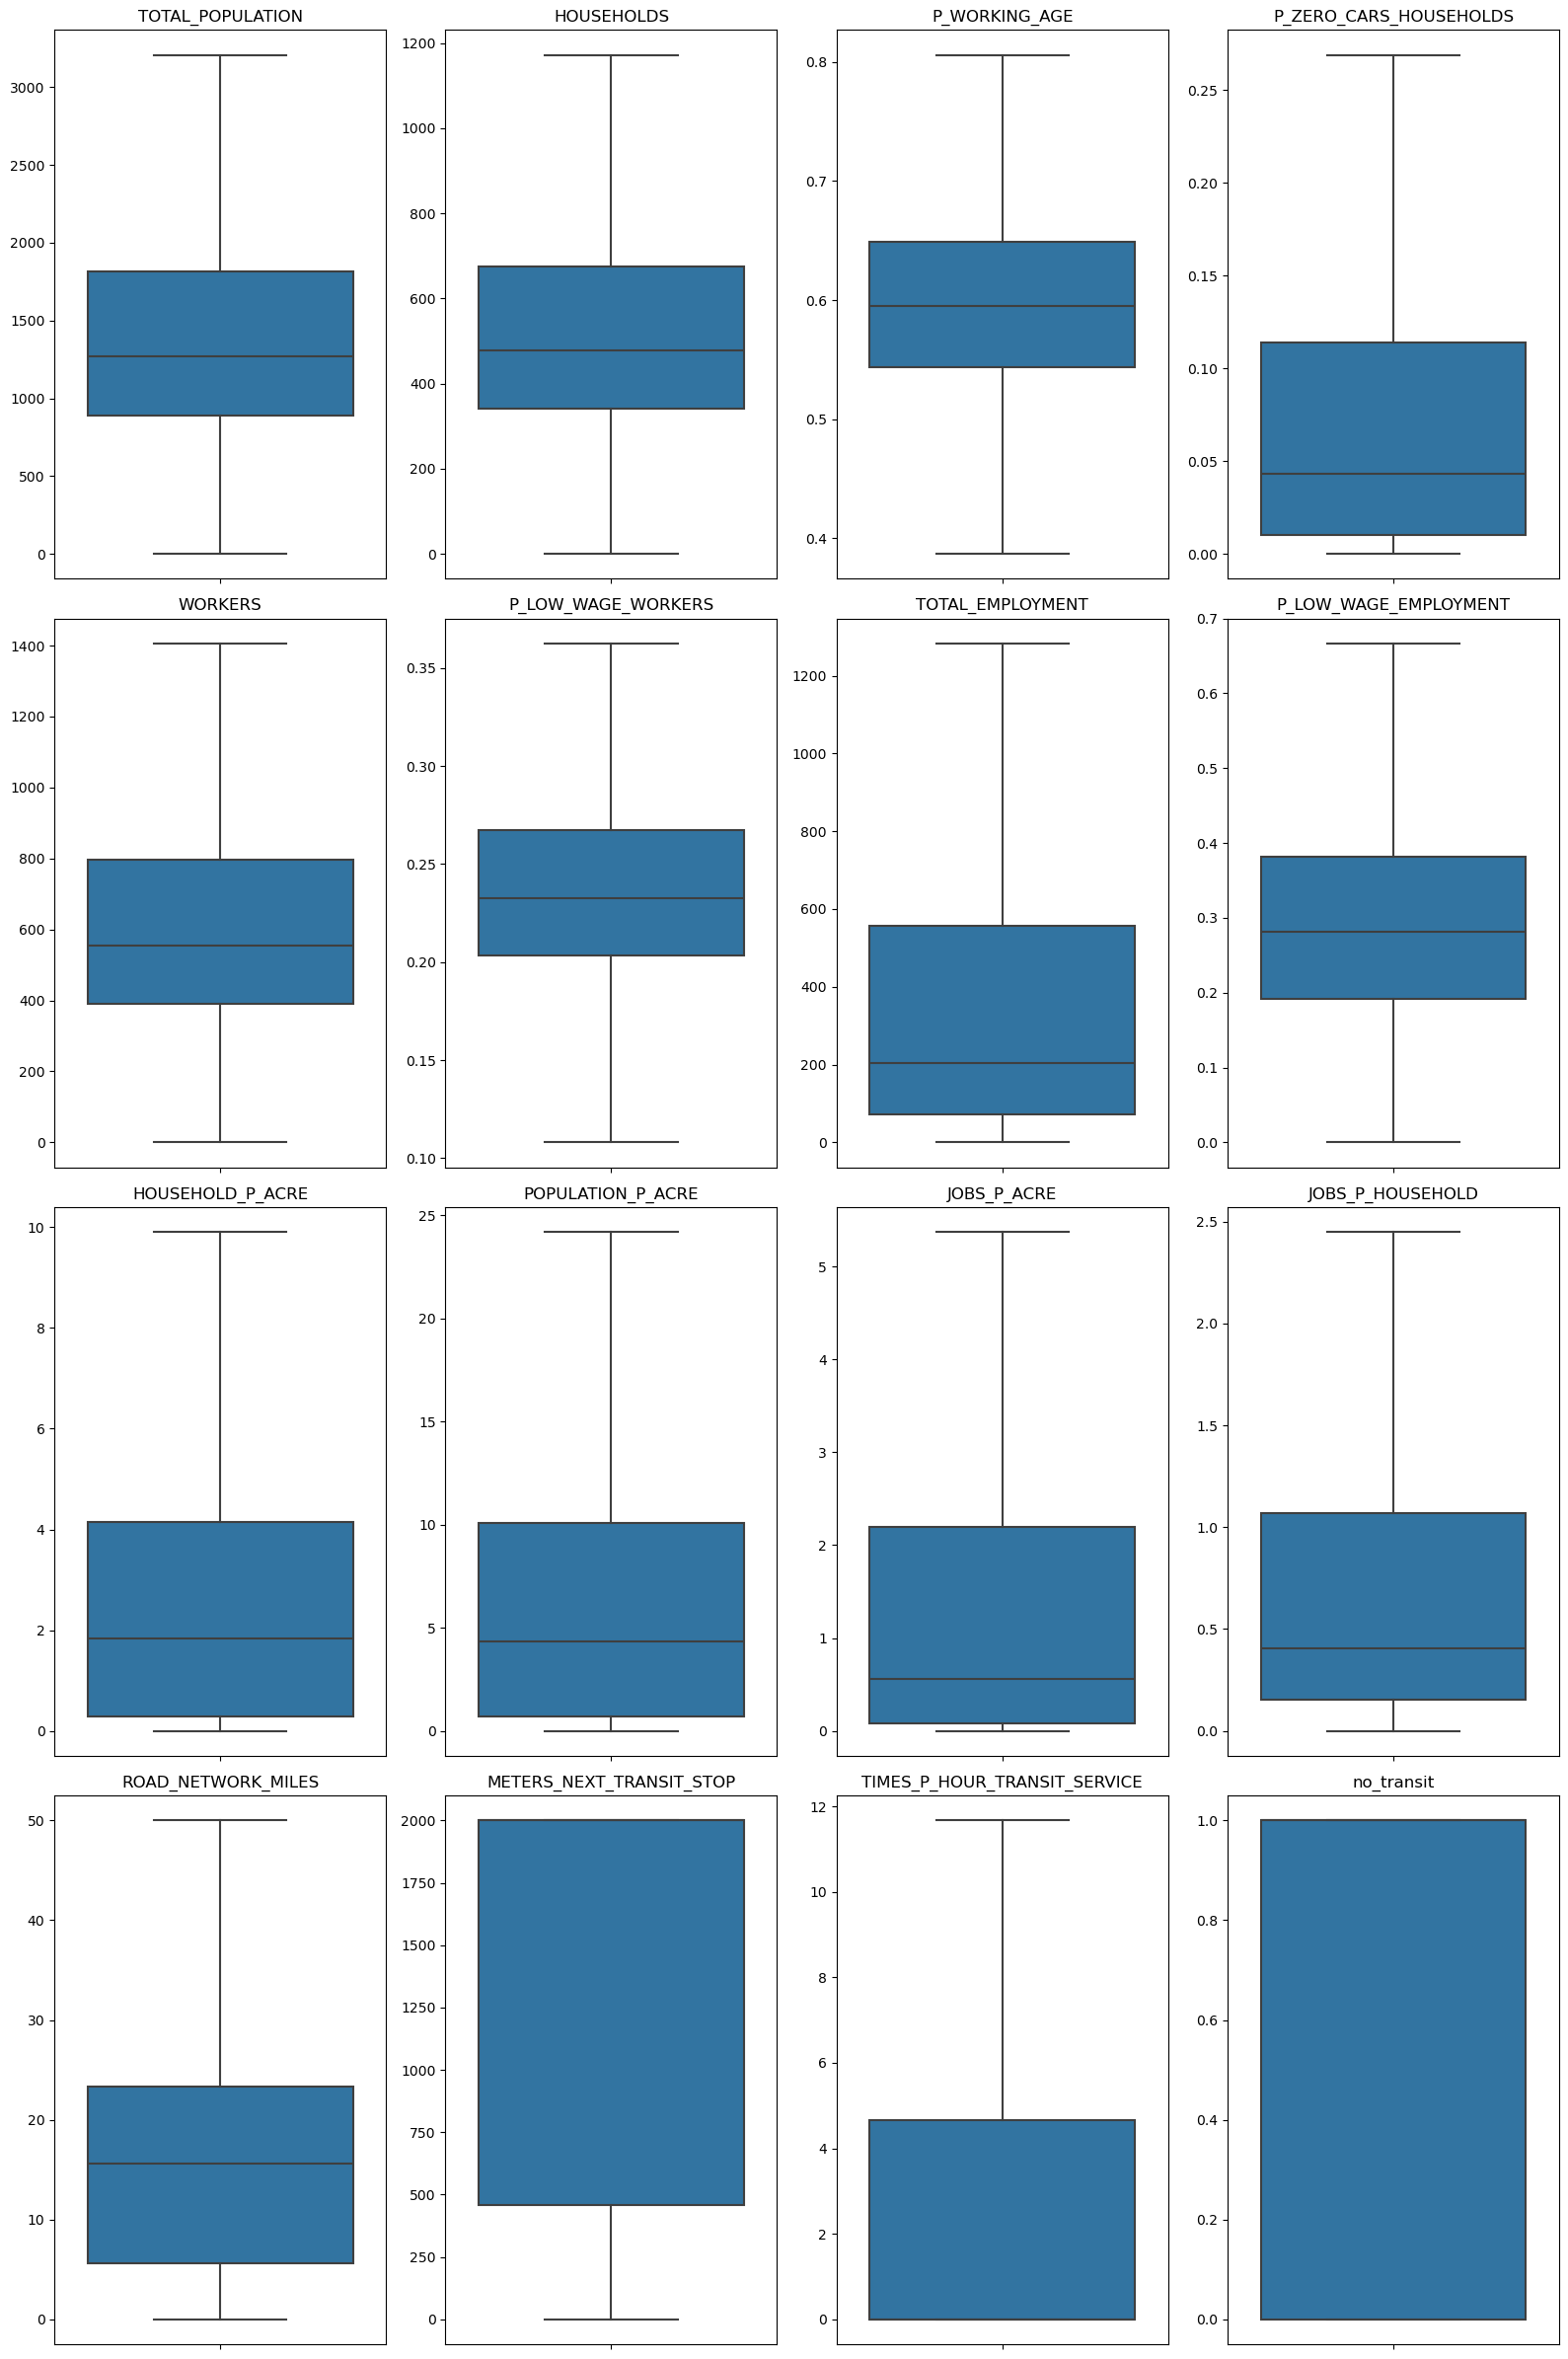

In [21]:
feature_df_numeric = feature_df.iloc[:, :]
num_cols = feature_df_numeric.shape[1]

# Create subplots: 4 rows and 4 columns
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(4 * 4, 6 * 4), sharey=False)

# Flatten the 2D axes array for easier iteration
axes = axes.flatten()

# Plot each column in its own subplot
for i, col in enumerate(feature_df_numeric.columns):
    sns.boxplot(y=feature_df_numeric[col], ax=axes[i], showfliers=False)
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')


plt.tight_layout()
plt.show()

In [22]:
print((feature_df == 0).sum())

TOTAL_POPULATION                  1057
HOUSEHOLDS                        1507
P_WORKING_AGE                     1081
P_ZERO_CARS_HOUSEHOLDS           49123
WORKERS                            705
P_LOW_WAGE_WORKERS                 871
TOTAL_EMPLOYMENT                  2162
P_LOW_WAGE_EMPLOYMENT             4426
HOUSEHOLD_P_ACRE                  1455
POPULATION_P_ACRE                 1058
JOBS_P_ACRE                       2166
JOBS_P_HOUSEHOLD                  2924
ROAD_NETWORK_MILES                 586
METERS_NEXT_TRANSIT_STOP          3106
TIMES_P_HOUR_TRANSIT_SERVICE    116318
no_transit                       94196
dtype: int64


The distributions look plausible.

<span style="color:red">Question: </span> 

I have a lot of elements which have no_transit: 56%. Does this effect my regression in any way?

Do I have to handle strong outliers like POPULATION_P_ACRE with max: 3133 and mean: 10?

### 3.2 Correlation

In [23]:
#feature_df

In [24]:
correlation_matrix = feature_df.corr(numeric_only=True)

In [25]:
correlation_matrix.round(2)

,TOTAL_POPULATION,HOUSEHOLDS,P_WORKING_AGE,P_ZERO_CARS_HOUSEHOLDS,WORKERS,P_LOW_WAGE_WORKERS,TOTAL_EMPLOYMENT,P_LOW_WAGE_EMPLOYMENT,HOUSEHOLD_P_ACRE,POPULATION_P_ACRE,JOBS_P_ACRE,JOBS_P_HOUSEHOLD,ROAD_NETWORK_MILES,METERS_NEXT_TRANSIT_STOP,TIMES_P_HOUR_TRANSIT_SERVICE,no_transit
TOTAL_POPULATION,1.00,0.90,0.05,-0.11,0.89,-0.13,0.12,-0.01,-0.00,0.03,-0.00,-0.01,-0.08,0.07,-0.01,0.06
HOUSEHOLDS,0.90,1.00,0.07,-0.06,0.87,-0.16,0.15,-0.01,0.05,0.03,0.01,-0.03,-0.08,0.08,0.02,0.06
P_WORKING_AGE,0.05,0.07,1.00,0.09,0.11,-0.04,0.08,0.02,0.14,0.13,0.06,0.02,0.22,-0.22,0.16,-0.20
P_ZERO_CARS_HOUSEHOLDS,-0.11,-0.06,0.09,1.00,-0.13,0.19,0.06,-0.01,0.50,0.50,0.14,0.01,0.38,-0.37,0.51,-0.31
WORKERS,0.89,0.87,0.11,-0.13,1.00,-0.24,0.13,-0.01,0.00,0.01,0.00,-0.02,-0.05,0.06,0.00,0.04
P_LOW_WAGE_WORKERS,-0.13,-0.16,-0.04,0.19,-0.24,1.00,-0.05,0.13,-0.09,-0.07,-0.04,0.01,-0.02,0.04,-0.11,0.05
TOTAL_EMPLOYMENT,0.12,0.15,0.08,0.06,0.13,-0.05,1.00,-0.14,-0.01,-0.02,0.28,0.19,0.05,-0.06,0.25,-0.06
P_LOW_WAGE_EMPLOYMENT,-0.01,-0.01,0.02,-0.01,-0.01,0.13,-0.14,1.00,-0.00,0.01,-0.04,-0.03,0.09,-0.03,-0.06,-0.03
HOUSEHOLD_P_ACRE,-0.00,0.05,0.14,0.50,0.00,-0.09,-0.01,-0.00,1.00,0.89,0.16,-0.01,0.33,-0.31,0.46,-0.27
POPULATION_P_ACRE,0.03,0.03,0.13,0.50,0.01,-0.07,-0.02,0.01,0.89,1.00,0.34,-0.00,0.36,-0.34,0.44,-0.29


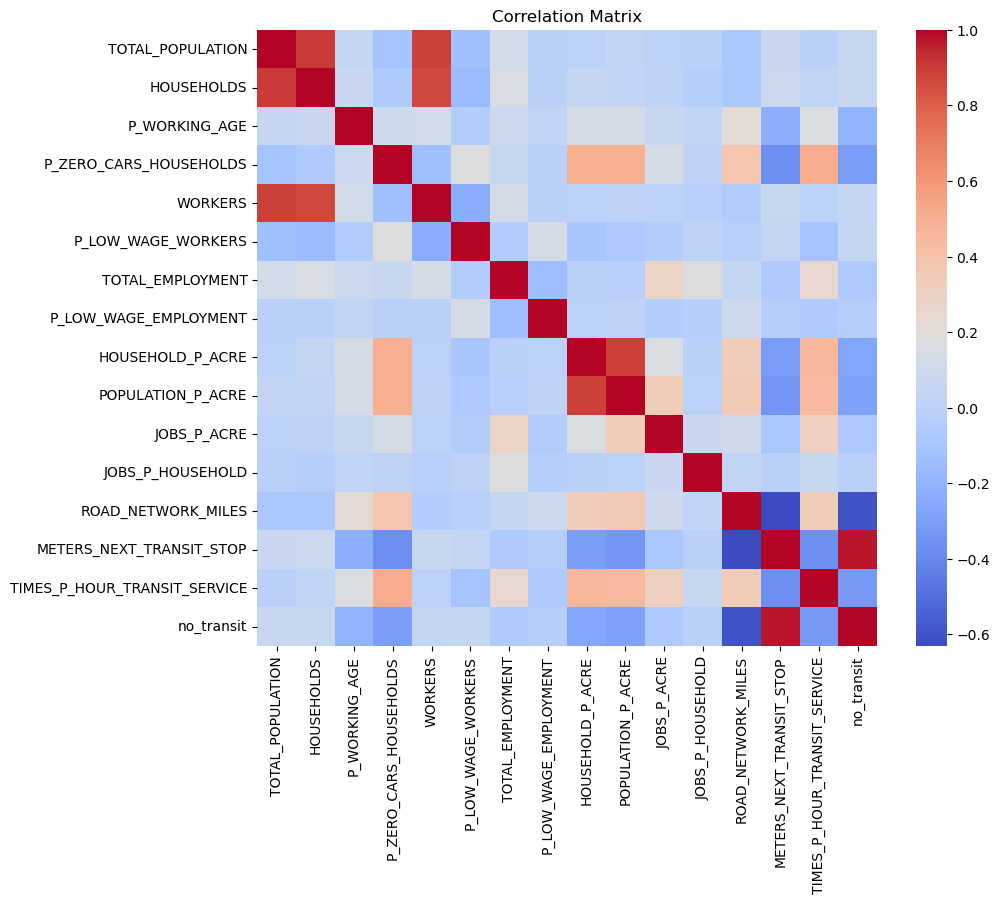

In [26]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.round(2), annot=False, cmap='coolwarm', fmt="2f")
plt.title("Correlation Matrix")
plt.show()

There are some pairs of variables displaying significant correlation.

## 4 Probabilistic Modeling Approach

### 4.1 Linear Models

#### (i) **Ordinary Least Squares (OLS)**

OLS minimizes the residual sum of squares:

$$
\hat{\beta} = \arg\min_{\beta} \| y - X\beta \|^2
$$

**Suitability**: OLS serves as a baseline due to its interpretability and closed-form solution. However, it may overfit in the presence of multicollinearity or noisy features.

---

#### (ii) **Ridge Regression (L2 Regularization)**

Ridge regression introduces an L2 penalty on the coefficients:

$$
\hat{\beta}_{\text{ridge}} = \arg\min_{\beta} \| y - X\beta \|^2 + \lambda \| \beta \|_2^2
$$

**Suitability**: Helps control overfitting by shrinking coefficients. Useful when predictors are correlated.

---

#### (iii) **Lasso Regression (L1 Regularization)**

Lasso regression introduces an L1 penalty:

$$
\hat{\beta}_{\text{lasso}} = \arg\min_{\beta} \| y - X\beta \|^2 + \lambda \| \beta \|_1
$$

**Suitability**: Encourages sparsity in coefficients and performs automatic feature selection.

---

#### (iv) **Elastic Net**

Elastic Net combines L1 and L2 regularization:

$$
\hat{\beta}_{\text{EN}} = \arg\min_{\beta} \| y - X\beta \|^2 + \lambda_1 \| \beta \|_1 + \lambda_2 \| \beta \|_2^2
$$

**Suitability**: Useful when there are many correlated features. Balances sparsity and regularization.

---

#### (v) **Bayesian Ridge Regression**

A probabilistic version of Ridge regression, assuming priors:

$$
p(\beta) = \mathcal{N}(0, \alpha^{-1} I), \quad p(y \mid X, \beta) = \mathcal{N}(X\beta, \eta^{-1} I)
$$

The posterior is:

$$
p(\beta \mid D) = \mathcal{N}(\mathbf{m}_N, \mathbf{S}_N)
$$

$$
\mathbf{S}_N = (\alpha I + \eta X^T X)^{-1}, \quad \mathbf{m}_N = \eta \mathbf{S}_N X^T y
$$

**Suitability**: Captures uncertainty in weights and includes automatic regularization.

---

### 4.2 Nonlinear Models

To address potential nonlinear relationships in the data, I explored the following models.

---

#### (i) **k-Nearest Neighbors (k-NN) Regression**

Predicts by averaging the target values of the k-nearest neighbors:

$$
\hat{y}(x) = \frac{1}{k} \sum_{i \in \mathcal{N}_k(x)} y_i
$$

**Suitability**: Non-parametric, data-driven. Best for low-dimensional, smooth problems.

---

#### (ii) **Random Forest Regressor**

An ensemble of decision trees trained on bootstrapped samples:

$$
\hat{y} = \frac{1}{T} \sum_{t=1}^{T} f_t(x)
$$

**Suitability**: Captures nonlinear interactions and is robust to overfitting. Suitable for bounded outputs and tabular data.

---

### 4.3 Summary of Suitability

| Model                | Strengths                                   | When to Use                                 |
|---------------------|---------------------------------------------|---------------------------------------------|
| OLS                 | Simple, interpretable                       | When relationships are linear               |
| Ridge               | Handles multicollinearity                   | Many correlated predictors                  |
| Lasso               | Feature selection                           | When sparsity is desired                    |
| Elastic Net         | Hybrid regularization                       | Correlated + sparse features                |
| Bayesian Ridge      | Uncertainty-aware, regularized              | Noisy/small data, Bayesian interpretation   |
| k-NN                | Simple, local, non-parametric               | Small, low-dim, smooth data                 |
| Random Forest       | Nonlinear, robust, interpretable            | Tabular data, feature interactions          |

## 5 Model Training and Evaluation

- Training process
- Model evaluation (metrics, plots, performance)
- Cross-validation or uncertainty quantification

### 5.1 Data

#### (i) Overview

In [27]:
feature_df

,TOTAL_POPULATION,HOUSEHOLDS,P_WORKING_AGE,P_ZERO_CARS_HOUSEHOLDS,WORKERS,P_LOW_WAGE_WORKERS,TOTAL_EMPLOYMENT,P_LOW_WAGE_EMPLOYMENT,HOUSEHOLD_P_ACRE,POPULATION_P_ACRE,JOBS_P_ACRE,JOBS_P_HOUSEHOLD,ROAD_NETWORK_MILES,METERS_NEXT_TRANSIT_STOP,TIMES_P_HOUR_TRANSIT_SERVICE,no_transit
0,1202,423.0,0.549,0.163121,412,0.240291,66,0.318182,6.250422,16.332625,0.896800,0.156028,23.534900,362.10,4.33,0
1,710,409.0,0.466,0.000000,395,0.192405,25,0.400000,3.430799,5.955666,0.209707,0.061125,22.893366,718.84,4.33,0
2,737,329.0,0.811,0.057751,463,0.293737,0,0.000000,13.843035,27.951553,0.000000,0.000000,14.210509,398.31,3.00,0
3,904,384.0,0.638,0.000000,431,0.139211,253,0.478261,3.225246,7.592767,2.124967,0.658854,32.178373,386.24,6.67,0
4,948,343.0,0.506,0.014577,579,0.157168,32,0.187500,2.305992,6.373413,0.215136,0.093294,22.058651,638.37,6.67,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217734,1251,557.0,0.580,0.034111,601,0.221298,49,0.306122,3.166905,6.737752,0.263909,0.087971,23.012779,2000.00,0.00,1
217735,1292,473.0,0.593,0.000000,513,0.214425,310,0.203226,1.330228,3.430449,0.823095,0.655391,20.675338,2000.00,0.00,1
217736,1055,456.0,0.596,0.046053,494,0.251012,228,0.478070,3.702966,8.567168,1.851483,0.500000,28.198149,2000.00,0.00,1
217737,833,425.0,0.586,0.120000,351,0.236467,497,0.271630,0.002295,0.003756,0.002241,1.169412,0.799596,2000.00,0.00,1


#### (ii) Splitting

In [28]:
y = feature_df["P_ZERO_CARS_HOUSEHOLDS"]
X = feature_df.drop(columns=["P_ZERO_CARS_HOUSEHOLDS","no_transit"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

#### (iii) Standardization

In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 5.2 Linear Models

#### (i) OLS

In [30]:
model = LinearRegression()
OLS_model = model.fit(X_train_scaled, y_train)
y_pred = OLS_model.predict(X_test_scaled)

metrics(y_test, y_pred)

Mean Squared Error (MSE): 0.009574
Root Mean Squared Error (RMSE): 0.097849
Mean Absolute Error (MAE): 0.064881
R² (Coefficient of Determination): 0.4778


#### (ii) L1 & L2

##### Determination of Alpha:


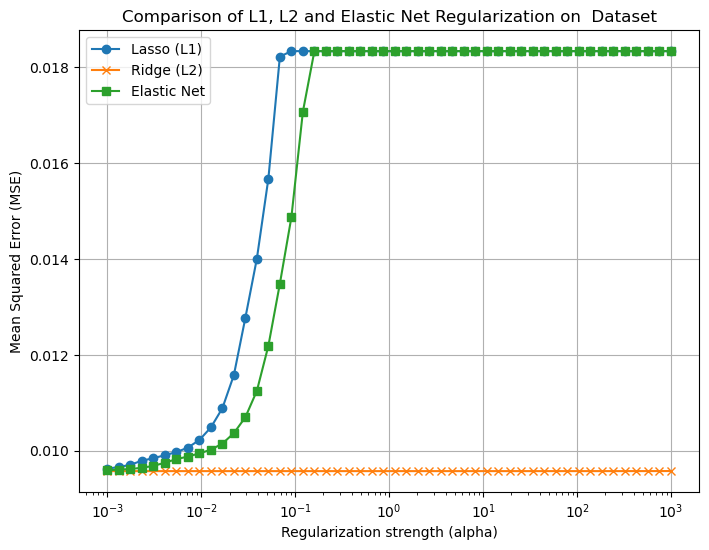


Best Lasso (L1) MSE for : 0.010 at alpha=0.001
Best Ridge (L2) MSE for : 0.010 at alpha=0.001
Best Elastic Net MSE for : 0.010 at alpha=0.001


In [31]:
compare_l1_l2_elastic(X_train_scaled, X_test_scaled, y_train, y_test, "")

##### Ridge

In [32]:
model = Ridge(alpha=0.001)
Ridge_model = model.fit(X_train_scaled, y_train)

y_pred = Ridge_model.predict(X_test_scaled)

metrics(y_test, y_pred)

Mean Squared Error (MSE): 0.009574
Root Mean Squared Error (RMSE): 0.097849
Mean Absolute Error (MAE): 0.064881
R² (Coefficient of Determination): 0.4778


##### Lasso

In [33]:
model = Lasso(alpha=0.001)
Lasso_model = model.fit(X_train_scaled, y_train)

y_pred = Lasso_model.predict(X_test_scaled)

metrics(y_test, y_pred)

Mean Squared Error (MSE): 0.009628
Root Mean Squared Error (RMSE): 0.098121
Mean Absolute Error (MAE): 0.064953
R² (Coefficient of Determination): 0.4749


##### ElasticNet

In [34]:
model = ElasticNet(alpha=0.001, l1_ratio=1)
EN_model = model.fit(X_train_scaled, y_train)

y_pred = EN_model.predict(X_test_scaled)

metrics(y_test, y_pred)

Mean Squared Error (MSE): 0.009628
Root Mean Squared Error (RMSE): 0.098121
Mean Absolute Error (MAE): 0.064953
R² (Coefficient of Determination): 0.4749


#### (iii) Bayesian Regression

In [35]:
model = BayesianRidge()
Bayesian_model = model.fit(X_train_scaled, y_train)

y_pred = Bayesian_model.predict(X_test_scaled)

metrics(y_test, y_pred)

Mean Squared Error (MSE): 0.009574
Root Mean Squared Error (RMSE): 0.097849
Mean Absolute Error (MAE): 0.064881
R² (Coefficient of Determination): 0.4778


#### (iv) Regularization

Regularization has no benefit in this case. 

Reasons:

No overfitting:

In [36]:
# Ridge: Test and Train prediction comparison 
y_pred = Ridge_model.predict(X_test_scaled)
print("Metrics for test data:")
metrics(y_test, y_pred)

print("")

y_pred = Ridge_model.predict(X_train_scaled)
print("Metrics for train data:")
metrics(y_train, y_pred)

Metrics for test data:
Mean Squared Error (MSE): 0.009574
Root Mean Squared Error (RMSE): 0.097849
Mean Absolute Error (MAE): 0.064881
R² (Coefficient of Determination): 0.4778

Metrics for train data:
Mean Squared Error (MSE): 0.009924
Root Mean Squared Error (RMSE): 0.099620
Mean Absolute Error (MAE): 0.065165
R² (Coefficient of Determination): 0.4616


Standardization:

In [37]:
y_pred = Ridge_model.predict(X_test_scaled)

print("R² for scaled data:", r2_score(y_test, y_pred))

print()

model = Ridge(alpha=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("R² for not scaled data:", r2_score(y_test, y_pred))

R² for scaled data: 0.4778341291951326

R² for not scaled data: 0.4778269502126672


Conclusion: L1 & L2 norms are not helping because the model is already well-behaved. there is no overfitting, and the features aren't causing instability in coefficient estimation.

### 5.3 Non Linear Models 

#### (i) k-NN

In [38]:
knn = KNeighborsRegressor(n_neighbors=5)
knn_model = knn.fit(X_train_scaled, y_train)

y_pred = knn_model.predict(X_test_scaled)

metrics(y_test, y_pred)

Mean Squared Error (MSE): 0.008317
Root Mean Squared Error (RMSE): 0.091199
Mean Absolute Error (MAE): 0.059590
R² (Coefficient of Determination): 0.5464


#### (ii) Random Forest Regressor

In [39]:
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split = 10,
    min_samples_leaf = 4,
    random_state=43,
    n_jobs=-1         
)
RF_model = model.fit(X_train_scaled, y_train)

y_pred = RF_model.predict(X_test_scaled)

metrics(y_test, y_pred)

Mean Squared Error (MSE): 0.006829
Root Mean Squared Error (RMSE): 0.082635
Mean Absolute Error (MAE): 0.054979
R² (Coefficient of Determination): 0.6276


### 5.4 Boundaries

#### (i) Linear Models

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


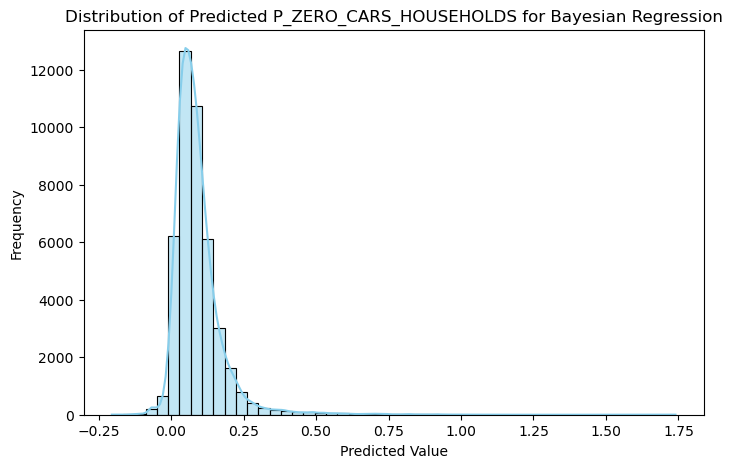

In [40]:
y_pred = Bayesian_model.predict(X_test_scaled)

# Plot distribution
plt.figure(figsize=(8, 5))
sns.histplot(y_pred, bins=50, kde=True, color='skyblue')
plt.title("Distribution of Predicted P_ZERO_CARS_HOUSEHOLDS for Bayesian Regression")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")
plt.show()

There are predictions in Linear Regression which are negative or above 1.0. These are wrong because percentage has a boundary from 0 to 1

#### (ii) Non Linear Models

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


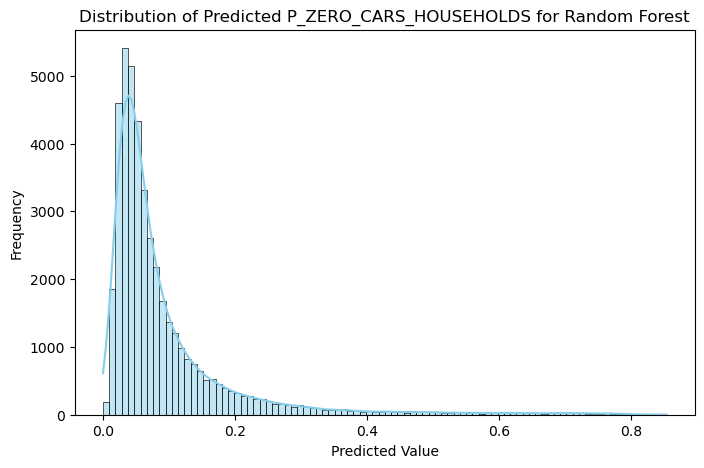

In [41]:
y_pred = RF_model.predict(X_test_scaled)

# Plot distribution
plt.figure(figsize=(8, 5))
sns.histplot(y_pred, bins=90, kde=True, color='skyblue')
plt.title("Distribution of Predicted P_ZERO_CARS_HOUSEHOLDS for Random Forest")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")
plt.show()

The non linear Model finds the right boundaries

### 5.5 Skewed Target 

(P_ZERO_CARS_HOUSEHOLDS) has a very skewed distribution
(Mean ≈ 0.09, Median ≈ 0.04, Max = 1.0)

#### (i) Test data

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


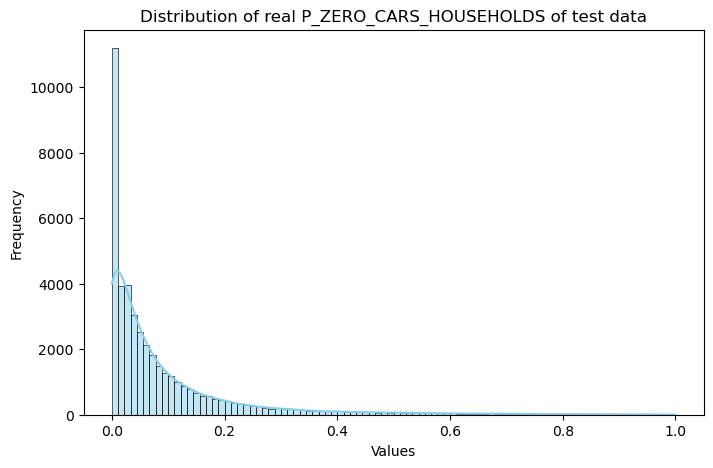

In [42]:
# Plot distribution of P_ZERO_CARS_HOUSEHOLDS Test
plt.figure(figsize=(8, 5))
sns.histplot(y_test, bins=90, kde=True, color='skyblue')
plt.title("Distribution of real P_ZERO_CARS_HOUSEHOLDS of test data")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.show()

The data is skewed with a high number of records with 0 values. These are rural areas with no transit. 

#### (ii) Random Forest

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


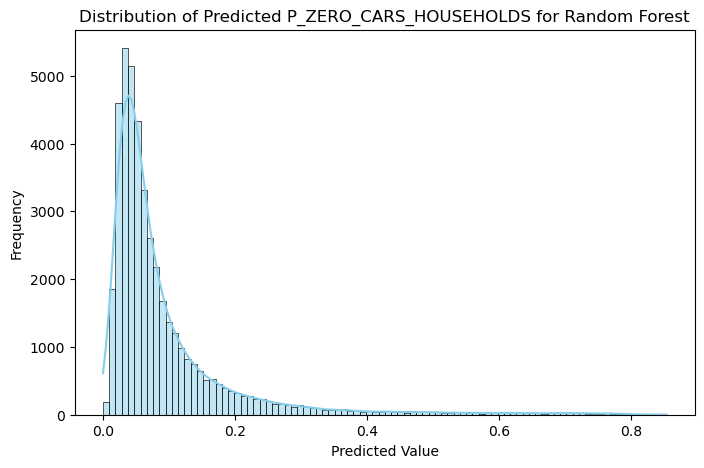

In [43]:
y_pred = RF_model.predict(X_test_scaled)

# Plot distribution
plt.figure(figsize=(8, 5))
sns.histplot(y_pred, bins=90, kde=True, color='skyblue')
plt.title("Distribution of Predicted P_ZERO_CARS_HOUSEHOLDS for Random Forest")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")
plt.show()

The model does not predict these high numbers of records with 0 values

#### (iii) Threshold

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


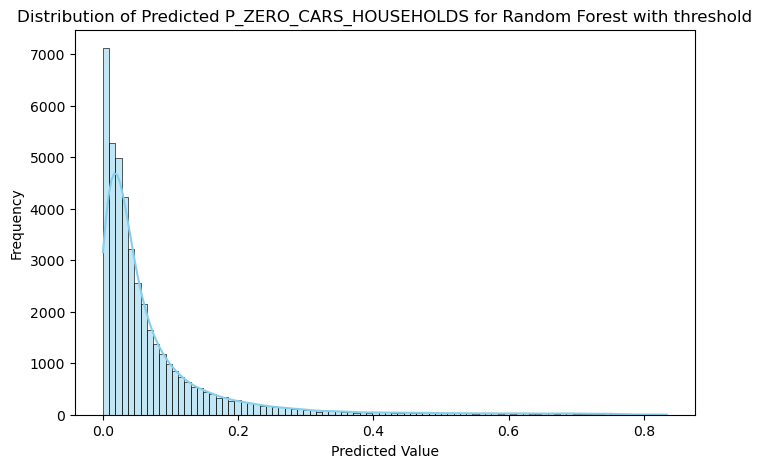

In [44]:
y_pred = RF_model.predict(X_test_scaled)

y_pred_adjusted = np.clip(y_pred - 0.02, 0, None)

# Plot distribution
plt.figure(figsize=(8, 5))
sns.histplot(y_pred_adjusted, bins=90, kde=True, color='skyblue')
plt.title("Distribution of Predicted P_ZERO_CARS_HOUSEHOLDS for Random Forest with threshold")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")
plt.show()

If a threshold is used to fit the predicted data closer to the real data regarding the records with 0 values. The distribution look more the same.

In [45]:
metrics(y_test, y_pred_adjusted)

Mean Squared Error (MSE): 0.007149
Root Mean Squared Error (RMSE): 0.084550
Mean Absolute Error (MAE): 0.053268
R² (Coefficient of Determination): 0.6101


A threshold will worsen the metrics slightly.

This adjustment highlights a common trade-off: By improving the model’s ability to match the observed distribution, particularly by accurately identifying records with 0% zero-car households, we accept a slight reduction in overall performance metrics in exchange for better representational accuracy in the critical lower end of the distribution

### 5.6 Coefficient strength and uncertainty

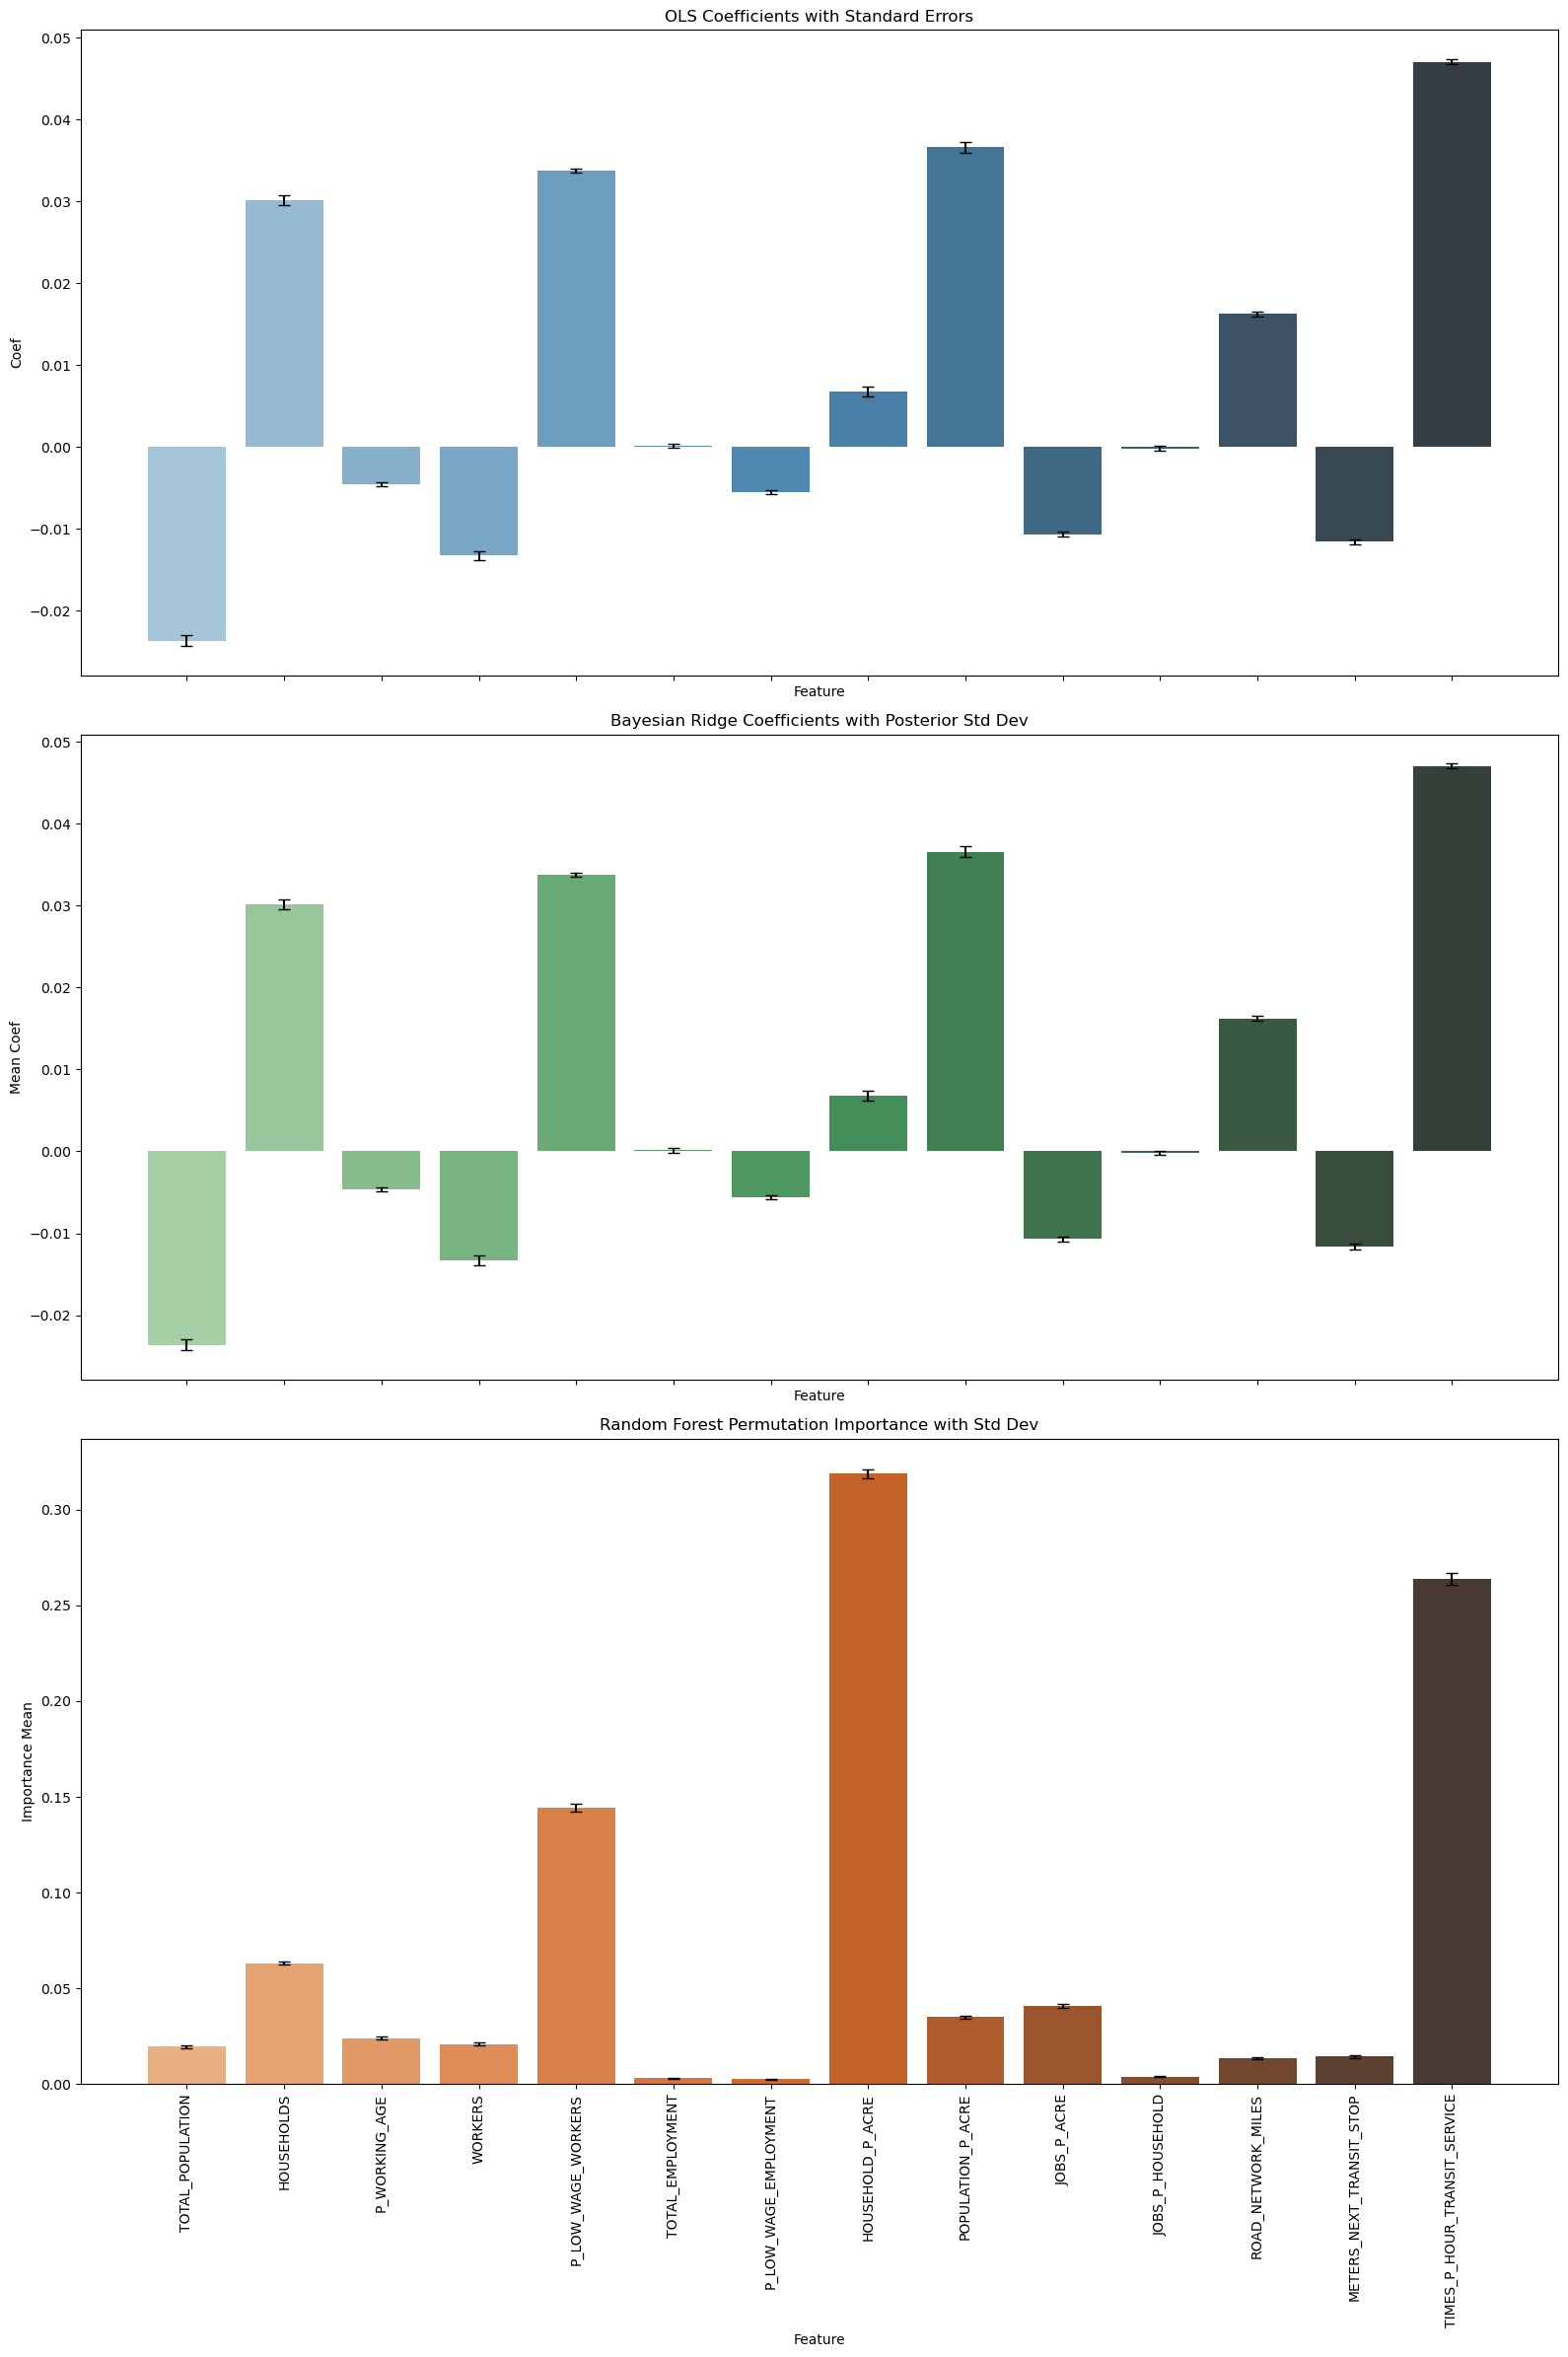

In [46]:
# OLS coefficients with statsmodels
X_train_const = sm.add_constant(X_train_scaled)  # add intercept
ols_model = sm.OLS(y_train, X_train_const).fit()
ols_summary = ols_model.summary2().tables[1].reset_index()
ols_summary.columns = ['Feature', 'Coef', 'Std Err', 't', 'P>|t|', '[0.025', '0.975]']
ols_summary = ols_summary[ols_summary['Feature'] != 'const']  # exclude intercept

# Bayesian Ridge coefficients and std dev
coef_summary = pd.DataFrame({
    'Feature': X_train.columns,
    'Mean Coef': Bayesian_model.coef_,
    'Std Dev': np.sqrt(np.diag(Bayesian_model.sigma_))
})

# Random Forest permutation importance
result = permutation_importance(
    RF_model, X_test_scaled, y_test, 
    n_repeats=30,
    random_state=43, 
    n_jobs=-1
)

df_perm = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std
})

# Plot 
fig, axes = plt.subplots(3, 1, figsize=(16, 24), sharex=True)

# OLS Coefficients
sns.barplot(
    data=ols_summary,
    x='Feature', y='Coef',
    ax=axes[0], palette='Blues_d', errorbar=None
)
axes[0].errorbar(
    x=np.arange(len(ols_summary)),
    y=ols_summary['Coef'],
    yerr=ols_summary['Std Err'],
    fmt='none', c='black', capsize=4
)
axes[0].set_title('OLS Coefficients with Standard Errors')
axes[0].tick_params(axis='x', rotation=90)

# Bayesian Ridge Coefficients
sns.barplot(
    data=coef_summary,
    x='Feature', y='Mean Coef',
    ax=axes[1], palette='Greens_d', errorbar=None
)
axes[1].errorbar(
    x=np.arange(len(coef_summary)),
    y=coef_summary['Mean Coef'],
    yerr=coef_summary['Std Dev'],
    fmt='none', c='black', capsize=4
)
axes[1].set_title('Bayesian Ridge Coefficients with Posterior Std Dev')
axes[1].tick_params(axis='x', rotation=90)

# Random Forest Importance
sns.barplot(
    data=df_perm,
    x='Feature', y='Importance Mean',
    ax=axes[2], palette='Oranges_d', errorbar=None
)
axes[2].errorbar(
    x=np.arange(len(df_perm)),
    y=df_perm['Importance Mean'],
    yerr=df_perm['Importance Std'],
    fmt='none', c='black', capsize=4
)
axes[2].set_title('Random Forest Permutation Importance with Std Dev')
axes[2].tick_params(axis='x', rotation=90)

# Layout
plt.tight_layout()
plt.show()

In [47]:
#OLS
print(ols_summary)

   Feature      Coef   Std Err           t          P>|t|    [0.025    0.975]
1       x1 -0.023672  0.000657  -36.024980  3.782886e-283 -0.024959 -0.022384
2       x2  0.030158  0.000601   50.179260   0.000000e+00  0.028980  0.031336
3       x3 -0.004591  0.000250  -18.364849   2.959124e-75 -0.005081 -0.004101
4       x4 -0.013283  0.000575  -23.082599  1.041541e-117 -0.014411 -0.012155
5       x5  0.033781  0.000255  132.541480   0.000000e+00  0.033282  0.034281
6       x6  0.000143  0.000270    0.530130   5.960228e-01 -0.000385  0.000671
7       x7 -0.005565  0.000245  -22.715157  4.653564e-114 -0.006046 -0.005085
8       x8  0.006783  0.000625   10.850483   2.024267e-27  0.005557  0.008008
9       x9  0.036611  0.000654   55.966587   0.000000e+00  0.035329  0.037893
10     x10 -0.010698  0.000305  -35.124673  2.500724e-269 -0.011295 -0.010101
11     x11 -0.000170  0.000246   -0.691338   4.893538e-01 -0.000653  0.000312
12     x12  0.016236  0.000319   50.902709   0.000000e+00  0.015

In [48]:
#Bayesian
print(coef_summary)

                         Feature  Mean Coef   Std Dev
0               TOTAL_POPULATION  -0.023634  0.000657
1                     HOUSEHOLDS   0.030117  0.000601
2                  P_WORKING_AGE  -0.004590  0.000250
3                        WORKERS  -0.013281  0.000575
4             P_LOW_WAGE_WORKERS   0.033777  0.000255
5               TOTAL_EMPLOYMENT   0.000143  0.000270
6          P_LOW_WAGE_EMPLOYMENT  -0.005564  0.000245
7               HOUSEHOLD_P_ACRE   0.006819  0.000625
8              POPULATION_P_ACRE   0.036573  0.000654
9                    JOBS_P_ACRE  -0.010686  0.000304
10              JOBS_P_HOUSEHOLD  -0.000171  0.000246
11            ROAD_NETWORK_MILES   0.016236  0.000319
12      METERS_NEXT_TRANSIT_STOP  -0.011605  0.000318
13  TIMES_P_HOUR_TRANSIT_SERVICE   0.047039  0.000299


In [49]:
# Random Forest
print(df_perm)

                         Feature  Importance Mean  Importance Std
0               TOTAL_POPULATION         0.019637        0.000748
1                     HOUSEHOLDS         0.063097        0.000803
2                  P_WORKING_AGE         0.023938        0.000849
3                        WORKERS         0.020879        0.000737
4             P_LOW_WAGE_WORKERS         0.144389        0.001902
5               TOTAL_EMPLOYMENT         0.003055        0.000210
6          P_LOW_WAGE_EMPLOYMENT         0.002511        0.000347
7               HOUSEHOLD_P_ACRE         0.318812        0.002279
8              POPULATION_P_ACRE         0.034931        0.000717
9                    JOBS_P_ACRE         0.040872        0.000859
10              JOBS_P_HOUSEHOLD         0.003848        0.000351
11            ROAD_NETWORK_MILES         0.013463        0.000602
12      METERS_NEXT_TRANSIT_STOP         0.014415        0.000653
13  TIMES_P_HOUR_TRANSIT_SERVICE         0.263825        0.003166


Magnitude and direction (Linear models):
Both Bayesian Ridge and OLS yield very similar coefficients and low uncertainties, showing consistent linear relationships with the target and clear positive or negative directions. For example, TIMES_P_HOUR_TRANSIT_SERVICE has the strongest positive linear association. The OLS standard errors confirm the stability and reliability of these estimates, matching the Bayesian posterior uncertainties.

Magnitude only (Random Forest):
Random Forest importance reflects feature relevance without direction, capturing non-linearities and interactions. Features like HOUSEHOLD_P_ACRE and TIMES_P_HOUR_TRANSIT_SERVICE have high importance, suggesting complex relationships beyond linear effects.

Consistency:
Features such as TIMES_P_HOUR_TRANSIT_SERVICE and P_LOW_WAGE_WORKERS are important across both linear and Random Forest models, increasing confidence in their true impact.

Discrepancies:
HOUSEHOLD_P_ACRE shows only a small linear effect in the linear models but is the most important feature in Random Forest, indicating a non-linear or interaction-driven role. Conversely, POPULATION_P_ACRE has a strong linear effect but lower RF importance, reflecting mostly linear influence. This contrast highlights how each model reveals different facets of feature relevance.

Uncertainty:
Both linear models provide stable, precise coefficient estimates with low uncertainty, while Random Forest permutation importance shows consistent feature importance across repeats, demonstrating confidence in the results.

### 5.7 Model uncertainty

In [50]:
# --- OLS Model ---
# Add constant (intercept)
X_train_const = sm.add_constant(X_train_scaled)
X_test_const = sm.add_constant(X_test_scaled)

# Fit OLS
ols_model = sm.OLS(y_train, X_train_const).fit()

# Get OLS predictions with standard errors of prediction
ols_pred = ols_model.get_prediction(X_test_const)
ols_pred_summary = ols_pred.summary_frame(alpha=0.05)  # 95% PI

# Extract mean prediction and standard deviation of prediction
y_pred_mean_ols = ols_pred_summary['mean'].values
# Calculate std from half width of 95% PI
y_pred_std_ols = (ols_pred_summary['mean_ci_upper'] - ols_pred_summary['mean_ci_lower']) / (2 * 1.96)

# --- Bayesian Ridge prediction + uncertainty ---
y_pred_mean_bayes, y_pred_std_bayes = Bayesian_model.predict(X_test_scaled, return_std=True)

# --- Random Forest prediction + uncertainty ---
all_tree_preds = np.stack([tree.predict(X_test_scaled) for tree in RF_model.estimators_], axis=0)
y_pred_mean_rf = np.mean(all_tree_preds, axis=0)
y_pred_std_rf = np.std(all_tree_preds, axis=0)

# --- Function to calculate coverage and average width ---
def uncertainty_metrics(y_true, y_pred_mean, y_pred_std, n_std=2):
    lower = y_pred_mean - n_std * y_pred_std
    upper = y_pred_mean + n_std * y_pred_std
    coverage = np.mean((y_true >= lower) & (y_true <= upper))
    avg_width = np.mean(upper - lower)
    mean_std = np.mean(y_pred_std)
    median_std = np.median(y_pred_std)
    return coverage, avg_width, mean_std, median_std

# --- Calculate metrics ---
coverage_ols, width_ols, mean_std_ols, median_std_ols = uncertainty_metrics(
    y_test.values, y_pred_mean_ols, y_pred_std_ols)

coverage_bayes, width_bayes, mean_std_bayes, median_std_bayes = uncertainty_metrics(
    y_test.values, y_pred_mean_bayes, y_pred_std_bayes)

coverage_rf, width_rf, mean_std_rf, median_std_rf = uncertainty_metrics(
    y_test.values, y_pred_mean_rf, y_pred_std_rf)

# --- Print results ---
print("OLS Prediction Uncertainty:")
print(f"  Coverage (±2 std): {coverage_ols:.3f}")
print(f"  Avg Interval Width: {width_ols:.4f}")
print(f"  Mean Predictive Std: {mean_std_ols:.5f}")
print(f"  Median Predictive Std: {median_std_ols:.5f}\n")

print("Bayesian Ridge Prediction Uncertainty:")
print(f"  Coverage (±2 std): {coverage_bayes:.3f}")
print(f"  Avg Interval Width: {width_bayes:.4f}")
print(f"  Mean Predictive Std: {mean_std_bayes:.5f}")
print(f"  Median Predictive Std: {median_std_bayes:.5f}\n")

print("Random Forest Prediction Uncertainty:")
print(f"  Coverage (±2 std): {coverage_rf:.3f}")
print(f"  Avg Interval Width: {width_rf:.4f}")
print(f"  Mean Predictive Std: {mean_std_rf:.5f}")
print(f"  Median Predictive Std: {median_std_rf:.5f}")


OLS Prediction Uncertainty:
  Coverage (±2 std): 0.016
  Avg Interval Width: 0.0029
  Mean Predictive Std: 0.00073
  Median Predictive Std: 0.00062

Bayesian Ridge Prediction Uncertainty:
  Coverage (±2 std): 0.953
  Avg Interval Width: 0.3985
  Mean Predictive Std: 0.09963
  Median Predictive Std: 0.09963

Random Forest Prediction Uncertainty:
  Coverage (±2 std): 0.926
  Avg Interval Width: 0.2295
  Mean Predictive Std: 0.05737
  Median Predictive Std: 0.04746


The OLS model has very low coverage (1.6%) and extremely narrow intervals, indicating it severely underestimates uncertainty and is overconfident. Bayesian Ridge shows near-ideal coverage (95.3%) but with quite wide intervals (0.3985), which may seem large given the true values are constrained between 0 and 1 — a narrow range—making these intervals look relatively big.

Random Forest offers a good tradeoff: slightly lower coverage (92.6%) but much narrower intervals (0.2295), providing more precise yet still fairly reliable uncertainty estimates. 

## 6 Results

- Present key findings
- Comparison of models if multiple approaches were used

## 7 Discussion

- Interpretation of results
- Limitations of the approach
- Possible improvements or extensions

## 8 Conclusion

- Summary of main outcomes

## 9 References

- Cite any papers, datasets, or tools used